# Data Preparation

In [318]:
import numpy as np
import pandas as pd
import datetime
from sklearn.metrics import mean_squared_error
from datetime import timedelta
import prophet
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
import seaborn as sns

In [319]:
# import transaction data
def read_transaction_by_Q(q):
    transactions = pd.read_csv(q+'.csv')
    transactions = transactions.sort_values(by="postDate")
    # reset the index
    transactions = transactions.reset_index(drop=True)
    return transactions

In [320]:
# ADDING NEW TOTAL BALANCE COLUMN
def process_transactions(transactions):

    # Get initial balance with the first 'balance' value
    initial_balance = transactions.at[0, 'balance']
    # Set the 'total_balance' of the first row to be the initial balance
    transactions.at[0, 'total_balance'] = initial_balance
    # Iterate through each row in transactions starting from the second row (index 1)
    for index, row in transactions.iterrows():
        if index == 0:
            continue  # Skip the first row since we already set the initial balance
        amount = row['amount']
        # calculate the running balance across all accounts
        initial_balance += amount
        # update the 'total_balance' column
        transactions.at[index, 'total_balance'] = initial_balance

    # Insert the 'total_balance' column at the specified position
    transactions.insert(7, 'total_balance', transactions.pop('total_balance'))

    #Drop unnecessary cols
    transactions = transactions[['total_balance', 'postDate']]

    try:
        transactions['postDate'] = pd.to_datetime(transactions['postDate'])
        # Set the 'postDate' column as the index
        return transactions
    except ValueError:
        print("Error: 'postDate' column could not be converted to datetime format.")
        return None

In [321]:
from scipy import stats
def group_data(transactions, option='mean'): # Set the 'postDate' column as the index

    if option == 'mean':
        transactions = transactions.groupby('postDate').agg({'total_balance': 'mean'}).reset_index()
    elif option == 'min':
        transactions = transactions.groupby('postDate').agg({'total_balance': 'min'}).reset_index()
    elif option == 'max':
        transactions = transactions.groupby('postDate').agg({'total_balance': 'max'}).reset_index()
    else:
        transactions = transactions.groupby('postDate').agg({'total_balance': 'sum'}).reset_index()

    # Reset the index to have 'postDate' as a regular column again
    transactions.set_index('postDate', inplace=False)
    transactions['postDate'] = pd.to_datetime(transactions['postDate'])
    transactions.set_index('postDate', inplace=True)

    # Then, resample the DataFrame with daily frequency and forward-fill missing values
    transactions = transactions.resample('D').ffill()

    # apply forward filling per each day
    return transactions

In [322]:
# visualise time series
import matplotlib.pyplot as plt
def plot_transactions(transactions, title):
    plt.figure(figsize=(12, 6))
    plt.plot(transactions['total_balance'])
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('total_balance')
    plt.show()

<ipython-input-320-e11cd4951d97>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions['postDate'] = pd.to_datetime(transactions['postDate'])


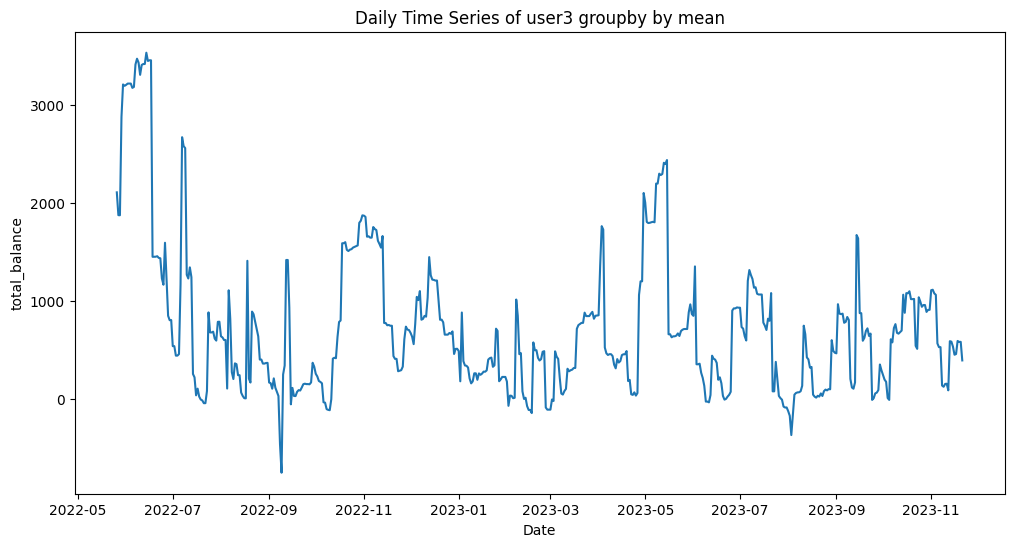

,total_balance
postDate,
2022-05-26 00:00:00+00:00,2106.09
2022-05-27 00:00:00+00:00,1874.09
2022-05-28 00:00:00+00:00,1873.09
2022-05-29 00:00:00+00:00,2873.09
2022-05-30 00:00:00+00:00,3204.09
...,...
2023-11-17 00:00:00+00:00,460.84
2023-11-18 00:00:00+00:00,593.64
2023-11-19 00:00:00+00:00,583.64


In [323]:
#Read Q data
def read_process_Q_data(Q, plot, option):
    Q_data = read_transaction_by_Q(Q)
    Q_data_processed = process_transactions(Q_data)
    if Q_data_processed is not None:
        Q_data_grouped = group_data(Q_data_processed, option=option)
        if plot:
            plot_transactions(Q_data_grouped, f'Daily Time Series of {Q} groupby by {option}')
    return Q_data_grouped

data = read_process_Q_data('user3', True, 'mean')
train_size = 0.9
data

# FB Prophet
* Cannot predict any value which is outside of the historic values in arima and XGBoost

## Starting

In [324]:
from pandas.api.types import CategoricalDtype

day = CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

# create function for check the result of test and predict data (average percentage of the prediction from the ground truth)
def test_results(y_test, y_predict):
  y_test, y_predict = np.array(y_test), np.array(y_predict)
  return np.mean(np.abs((y_test - y_predict) / y_test)) * 100

# creating features for the feature engineering for the X set
def feature_creation(df, label=None):
  data = df.copy()
  data['date'] = data.index
  data['dayofweek'] = data['date'].dt.dayofweek
  data['weekday'] = data['date'].dt.day_name()
  data['weekday'] = data['weekday'].astype(day)
  data['quarter'] = data['date'].dt.quarter
  data['month'] = data['date'].dt.month
  data['dayofmonth'] = data['date'].dt.day
  data['weekofyear'] = data['date'].dt.week

  X = data[['dayofweek', 'quarter', 'month', 'dayofmonth', 'weekofyear', 'weekday']]

  if label:
    y = df[label]
    return X, y
  return X

In [325]:
FB_data = data
X, y = feature_creation(FB_data, 'total_balance') # allocating features for each value
features_target = pd.concat([X, y], axis=1)

<ipython-input-324-4b532c4173f2>:20: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  data['weekofyear'] = data['date'].dt.week


## Train and Test Sets

In [326]:
def split_data (data, train):
    # Calculate the index to split the data
    split_index = int(len(data) * train)

    # Split the data
    train_data = data[:split_index]
    test_data = data[split_index:]

    return train_data, test_data

In [327]:
train, test = split_data(FB_data, train=train_size) # train percentage is 80%

## Prophet Model

In [328]:
PB_train_data = train.reset_index().rename(columns={'postDate':'ds','total_balance' : 'y'})
PB_test_data = test.reset_index().rename(columns={'postDate':'ds','total_balance' : 'y'})
PB_train_data['ds'] = pd.to_datetime(PB_train_data['ds']).dt.tz_localize(None)
PB_test_data['ds'] = pd.to_datetime(PB_test_data['ds']).dt.tz_localize(None)

In [329]:
import prophet as pb

In [330]:
model = pb.Prophet(daily_seasonality=True)
model.fit(PB_train_data)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiaifslkc/nrtx10zn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpiaifslkc/264lfs3e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82682', 'data', 'file=/tmp/tmpiaifslkc/nrtx10zn.json', 'init=/tmp/tmpiaifslkc/264lfs3e.json', 'output', 'file=/tmp/tmpiaifslkc/prophet_model_v4rv0dq/prophet_model-20231208055722.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
05:57:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:57:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [331]:
forecast = model.predict(PB_test_data)

In [332]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-09-28,740.875663,-353.842841,1363.128431,740.875663,740.875663,-222.642266,-222.642266,-222.642266,-243.058826,-243.058826,-243.058826,20.416560,20.416560,20.416560,0.0,0.0,0.0,518.233397
1,2023-09-29,740.387769,-369.020772,1357.837989,740.387769,740.387769,-250.024746,-250.024746,-250.024746,-243.058826,-243.058826,-243.058826,-6.965920,-6.965920,-6.965920,0.0,0.0,0.0,490.363022
2,2023-09-30,739.899874,-411.342023,1283.440966,739.899874,739.899874,-260.152376,-260.152376,-260.152376,-243.058826,-243.058826,-243.058826,-17.093550,-17.093550,-17.093550,0.0,0.0,0.0,479.747498
3,2023-10-01,739.411980,-332.440080,1346.971285,739.411980,739.411980,-251.278362,-251.278362,-251.278362,-243.058826,-243.058826,-243.058826,-8.219536,-8.219536,-8.219536,0.0,0.0,0.0,488.133618
4,2023-10-02,738.924086,-341.528030,1365.992551,738.818894,738.995383,-239.025486,-239.025486,-239.025486,-243.058826,-243.058826,-243.058826,4.033340,4.033340,4.033340,0.0,0.0,0.0,499.898600
5,2023-10-03,738.436192,-347.992676,1385.122256,738.192763,738.689544,-227.224453,-227.224453,-227.224453,-243.058826,-243.058826,-243.058826,15.834373,15.834373,15.834373,0.0,0.0,0.0,511.211739
6,2023-10-04,737.948297,-399.469173,1344.900970,737.463389,738.405099,-251.064094,-251.064094,-251.064094,-243.058826,-243.058826,-243.058826,-8.005268,-8.005268,-8.005268,0.0,0.0,0.0,486.884203
7,2023-10-05,737.460403,-397.168487,1337.973863,736.699954,738.117491,-222.642266,-222.642266,-222.642266,-243.058826,-243.058826,-243.058826,20.416560,20.416560,20.416560,0.0,0.0,0.0,514.818137
8,2023-10-06,736.972509,-360.605681,1374.210518,735.864018,737.957345,-250.024746,-250.024746,-250.024746,-243.058826,-243.058826,-243.058826,-6.965920,-6.965920,-6.965920,0.0,0.0,0.0,486.947763
9,2023-10-07,736.484614,-384.241383,1343.995137,735.068897,737.691456,-260.152376,-260.152376,-260.152376,-243.058826,-243.058826,-243.058826,-17.093550,-17.093550,-17.093550,0.0,0.0,0.0,476.332238


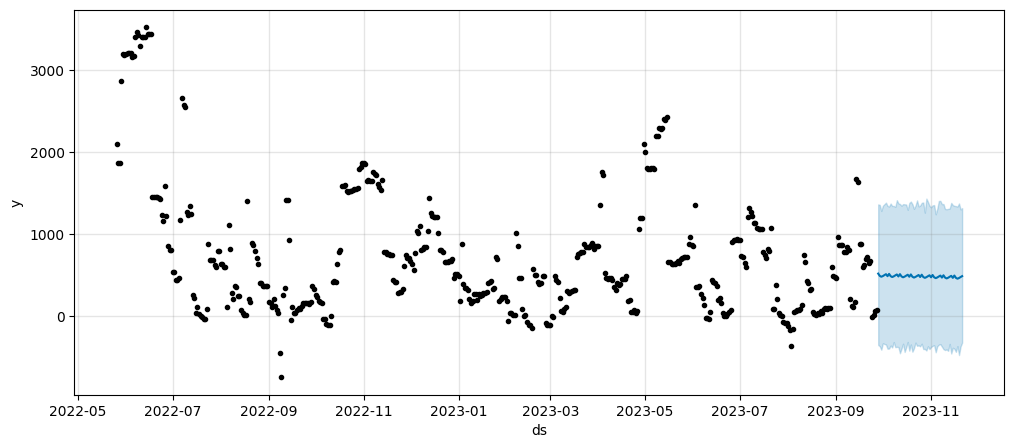

In [333]:
fig, ax = plt.subplots(figsize=(12, 5))
fig = model.plot(forecast, ax=ax)
plt.show()

Root Mean Squared Error: 372.63788691740547



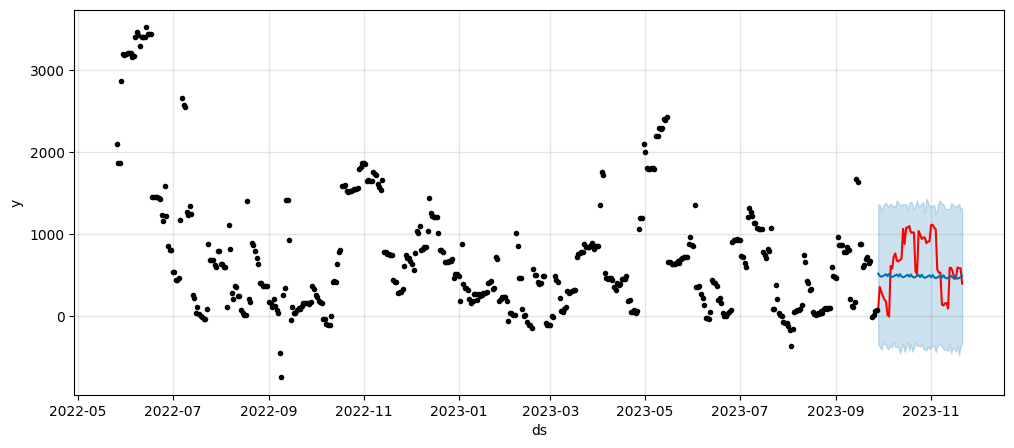

In [334]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(test.index, test['total_balance'], color='r')
fig = model.plot(forecast, ax=ax)

# calculating the root mean squared
rmse = np.sqrt(mean_squared_error(test['total_balance'], forecast['yhat']))
print("Root Mean Squared Error:", rmse)

print()

# FORCASTING 1 YEAR INTO THE FUTURE

In [335]:
future = model.make_future_dataframe(periods=365)
new_forecast = model.predict(future)

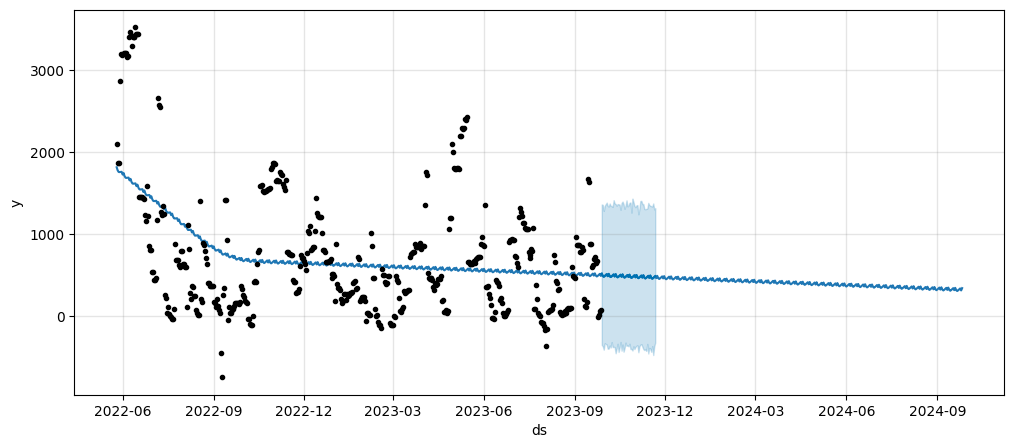

In [336]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(future, new_forecast['yhat'])
fig = model.plot(forecast, ax=ax)